In [14]:
# %%lock
import requests
import bs4 
import pandas as pd
import scipy as sc
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from phik import phik_matrix
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from scipy.stats import pointbiserialr
from sklearn.metrics import roc_auc_score





In [ ]:
you need to install this pip's for selenium and phik

In [1]:

#!pip install phik
#pip install selenium

# Set the path for the webdriver for selenium use


In [234]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

chrome_driver_path = 'C:\\Users\\idanb\\Downloads\\chromedriver_win32\\chromedriver.exe'
# Start the WebDriver
service = Service(chrome_driver_path)
driver = webdriver.Chrome(service=service)


# Crawling

In [235]:
#running on the main page of all the resturants 
base_url = 'https://www.rest.co.il/restaurants/israel/'
driver.get('https://www.rest.co.il/restaurants/israel/')
html_pages = []
inspect_code = driver.execute_script("return document.documentElement.outerHTML")
for i in range(1,157):
    url = base_url + 'page-'+ str(i)+'/'
    driver.get(url)
    inspect_code = driver.execute_script("return document.documentElement.outerHTML")
    html_pages.append(inspect_code)

    

In [4]:
#parser all the HTML pages 
parsed_pages = []

for html_content in html_pages:
    soup = BeautifulSoup(html_content, 'html.parser')
    parsed_pages.append(soup)  # Store the parsed HTML for the current page
driver.quit()


In [5]:
#running on all the pages and extarct the Name and the link to the restuarnt
linkstopage = []
for soup in parsed_pages:
    linkstopage.extend(soup.findAll("div", attrs={"class": "rest-title"}))

restaurants = []
for div in linkstopage:
    for a in div.find_all('a'):
        restaurant_name = a.text.strip()
        restaurant_href = a['href']
        restaurants.append((restaurant_name, restaurant_href))

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
df = pd.DataFrame(restaurants, columns=['Restaurant Name', 'Href'])
df

<IPython.core.display.Javascript object>

In [7]:
service = Service(chrome_driver_path)
driver = webdriver.Chrome(service=service)
base_url = 'https://www.rest.co.il'
for index, row in df.iterrows():
    restaurant_name = row['Restaurant Name']
    href = row['Href']
    full_href = base_url + href

    # Navigate to the URL
    driver.get(full_href)

    try:
        # Find the <div class="popup additional-features"> and perform fake button click
        popup_div = driver.find_element(By.CSS_SELECTOR, 'div.popup.additional-features')
        popup_div.click()

        try:
            # Find the <div class="pop-scroll-wrap"> and extract <li> tags
            scroll_div = driver.find_element(By.CSS_SELECTOR, 'div.pop-scroll-wrap')
            li_tags = scroll_div.find_elements(By.TAG_NAME, 'li')

            # Extract text from each <li> tag and update the DataFrame with binary features
            for li_tag in li_tags:
                li_text = li_tag.text.strip()
                column_name = f'Feature: {li_text}'

                if column_name in df.columns:
                    # Feature already exists, update the value to 1
                    df.loc[index, column_name] = 1
                else:
                    # Feature doesn't exist, create a new column and set the value to 1
                    df[column_name] = 0
                    df.loc[index, column_name] = 1

        except NoSuchElementException:
            continue  # <div class="pop-scroll-wrap"> not found, continue without extracting

    except NoSuchElementException:
        try:
            # Find the <div class="place_info"> and extract <li> tags
            place_info_div = driver.find_element(By.CSS_SELECTOR, 'div.place_info')
            li_tags = place_info_div.find_elements(By.TAG_NAME, 'li')

            # Extract text from each <li> tag and update the DataFrame with binary features
            for li_tag in li_tags:
                li_text = li_tag.text.strip()
                column_name = f'{li_text}'

                if column_name in df.columns:
                    # Feature already exists, update the value to 1
                    df.loc[index, column_name] = 1
                else:
                    # Feature doesn't exist, create a new column and set the value to 1
                    df[column_name] = 0
                    df.loc[index, column_name] = 1

        except NoSuchElementException:
            continue  # <div class="place_info"> not found, continue without extracting

        try:
            # Find the <div class="reviews_box"> and extract the <span> tag
            reviews_box_div = driver.find_element(By.CSS_SELECTOR, 'div.reviews_box')
            span_tag = reviews_box_div.find_element(By.TAG_NAME, 'span')

            # Extract the text from the <span> tag and update the DataFrame
            span_text = span_tag.text.strip()
            df.loc[index, 'Review Text'] = span_text

        except NoSuchElementException:
            continue 

    


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
driver.quit()





# Data Cleaning

In [380]:
df = pd.read_csv('zap_rest_data_base.csv')
df

,Restaurant Name,Href,Take Away,נגישות לנכים,לסילבסטר,"פתוח במוצ""ש",מסעדה לא כשרה,Review Text,שירותי קייטרינג,שירות הזמן שולחן,...,סדנאות בישול במסעדה,משלוחים חינם,אירועים מעל 300 איש,הופעות חיות,dog friendly,שף עד הבית,הנחות לחיילים,וידיאו קונפרנס,מסעדה עם לינה,אירועים עד 300 איש
0,דגי בטשון - BATSHON,/rest/80316964/,1,1,1,1,1,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,נסיבה אירוח דרוזי וסיפורים - naseeba,/rest/80250644/,0,0,0,1,0,4.5,1,1,...,0,0,0,0,0,0,0,0,0,0
2,בראל - בר תוצרת הארץ - BAREL BAR,/rest/80351389/,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,אושפזין קייטרינג ואוכל מוכן לשבת,/rest/80348164/,1,0,0,0,0,5.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,BBB הכשר - קריית גת,/rest/80345468/,0,0,0,1,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23605,בית מאפה מאיה,/rest/80115559/,0,0,0,0,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
23606,אשטו בורגר,/rest/80350074/,0,0,0,0,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
23607,ניקה,/rest/80358591/,0,0,0,0,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
23608,BURGER COMPANY בורגר קומפני בת ים - BURGER COM...,/rest/80304960/,0,0,0,0,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [381]:
#change the english features to Hebrew
df.rename(columns={'Wi-fi': 'ויי-פיי'}, inplace=True)
df.rename(columns={'Take Away': 'איסוף עצמי'}, inplace=True)

In [382]:
print(df['Review Text'].isna().sum())

22993


In [383]:
#cleaning all the sampels with no rating value (NaN) 
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df.index = df.index + 1
df

,Restaurant Name,Href,איסוף עצמי,נגישות לנכים,לסילבסטר,"פתוח במוצ""ש",מסעדה לא כשרה,Review Text,שירותי קייטרינג,שירות הזמן שולחן,...,סדנאות בישול במסעדה,משלוחים חינם,אירועים מעל 300 איש,הופעות חיות,dog friendly,שף עד הבית,הנחות לחיילים,וידיאו קונפרנס,מסעדה עם לינה,אירועים עד 300 איש
1,דגי בטשון - BATSHON,/rest/80316964/,1,1,1,1,1,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,נסיבה אירוח דרוזי וסיפורים - naseeba,/rest/80250644/,0,0,0,1,0,4.5,1,1,...,0,0,0,0,0,0,0,0,0,0
3,בראל - בר תוצרת הארץ - BAREL BAR,/rest/80351389/,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,אושפזין קייטרינג ואוכל מוכן לשבת,/rest/80348164/,1,0,0,0,0,5.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,פיש - FISH,/rest/80115399/,0,0,0,1,1,4.5,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,קורסר Corsar - cor sar,/rest/80250221/,1,0,0,1,1,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
614,זואי,/rest/80334874/,0,0,0,0,0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
615,"Frame פריים ראשל""צ",/rest/80260867/,0,0,0,0,0,3.5,0,0,...,0,0,0,0,0,0,0,0,0,0
616,the view,/rest/80365907/,0,0,0,0,0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [384]:
features_to_remove = ['Restaurant Name', 'Href']

# Drop the features from the DataFrame
df = df.drop(features_to_remove, axis=1)

In [385]:
#Distribution of the rating 
df['Review Text'].value_counts()

4.0    193
5.0    137
4.5    110
3.5    100
3.0     60
2.5      8
2.0      4
1.0      4
1.5      1
Name: Review Text, dtype: int64

In [386]:
# Remove the features that have less then 20 '1' from the DataFrame
features_to_remove = []
for column in df.columns:
     if column != 'Review Text':
        value_counts = df[column].value_counts()
        count_0 = value_counts.get(0, 0)
        count_1 = value_counts.get(1, 0)
        if count_1 < 20:
            features_to_remove.append(column)
        print("Feature:", column)
        print("Count of 0s:", count_0)
        print("Count of 1s:", count_1)
        print("-----------------------")

Feature: איסוף עצמי
Count of 0s: 424
Count of 1s: 193
-----------------------
Feature: נגישות לנכים
Count of 0s: 508
Count of 1s: 109
-----------------------
Feature: לסילבסטר
Count of 0s: 425
Count of 1s: 192
-----------------------
Feature: פתוח במוצ"ש
Count of 0s: 263
Count of 1s: 354
-----------------------
Feature: מסעדה לא כשרה
Count of 0s: 539
Count of 1s: 78
-----------------------
Feature: שירותי קייטרינג
Count of 0s: 589
Count of 1s: 28
-----------------------
Feature: שירות הזמן שולחן
Count of 0s: 462
Count of 1s: 155
-----------------------
Feature: פתוח בשבת
Count of 0s: 433
Count of 1s: 184
-----------------------
Feature: מסיבות חברה
Count of 0s: 586
Count of 1s: 31
-----------------------
Feature: ימי כיף
Count of 0s: 556
Count of 1s: 61
-----------------------
Feature: פתוח בשישי
Count of 0s: 363
Count of 1s: 254
-----------------------
Feature: מסעדות כשרות
Count of 0s: 517
Count of 1s: 100
-----------------------
Feature: אוכל מוכן לשבת/ לקחת
Count of 0s: 603
Count o

In [387]:
# Remove the features from the DataFrame
df_filtered = df.drop(features_to_remove, axis=1)
df_filtered.head()

,איסוף עצמי,נגישות לנכים,לסילבסטר,"פתוח במוצ""ש",מסעדה לא כשרה,Review Text,שירותי קייטרינג,שירות הזמן שולחן,פתוח בשבת,מסיבות חברה,...,לוקיישן לצילום,משלוחים,עסק שומר שבת,הדרכות/סדנאות,מסעדה כשרה למהדרין,ימי נישואין,אפשרות ישיבה בחוץ,כנסים,מסעדה עם חניה מוסדרת,מסיבות רווקים/רווקות
1,1,1,1,1,1,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,4.5,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,5.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,1,4.5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

In [388]:
print(df_filtered.columns)

Index(['איסוף עצמי', 'נגישות לנכים', 'לסילבסטר', 'פתוח במוצ"ש',
       'מסעדה לא כשרה', 'Review Text', 'שירותי קייטרינג', 'שירות הזמן שולחן',
       'פתוח בשבת', 'מסיבות חברה', 'ימי כיף', 'פתוח בשישי', 'מסעדות כשרות',
       'גישה לתחבורה ציבורית', 'גינה חיצונית', 'ציוד הגברה', 'מסעדות עם מקרן',
       'קוקטייל', 'ערבי מחלקה', 'אירועים קטנים', 'אזור עישון', 'ויי-פיי',
       'תצוגות אופנה', 'תערוכות', 'מסעדה לאירועים וכנסים',
       'מסעדה עם חניה חינם', 'ימי הולדת', 'לוקיישן לצילום', 'משלוחים',
       'עסק שומר שבת', 'הדרכות/סדנאות', 'מסעדה כשרה למהדרין', 'ימי נישואין',
       'אפשרות ישיבה בחוץ', 'כנסים', 'מסעדה עם חניה מוסדרת',
       'מסיבות רווקים/רווקות'],
      dtype='object')


In [389]:
#here we inspect the resturant rating 
df_filtered['Review Text'].value_counts(normalize=True)

4.0    0.312804
5.0    0.222042
4.5    0.178282
3.5    0.162075
3.0    0.097245
2.5    0.012966
2.0    0.006483
1.0    0.006483
1.5    0.001621
Name: Review Text, dtype: float64

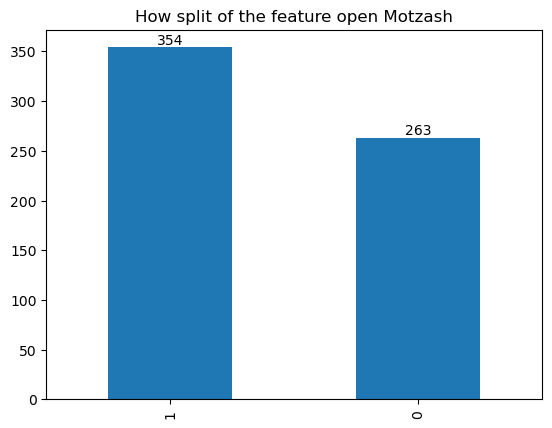

In [390]:
ax = df_filtered['פתוח במוצ"ש'].value_counts().plot(kind='bar')
# Add numeric values on each bar
for i, value in enumerate(df_filtered['פתוח במוצ"ש'].value_counts()):
    ax.annotate(str(value), (i, value), ha='center', va='bottom')
plt.title('How split of the feature open Motzash')
plt.show()

In [391]:
#search for the highest correlation between features
correlation_matrix = df_filtered.corr()
high_corr_features = []
# Filter the correlation matrix for values greater than 0.4
high_correlation = correlation_matrix[correlation_matrix > 0.4]

# Drop the diagonal elements (correlation of a feature with itself)
high_correlation = high_correlation.dropna(how='all').dropna(axis=1, how='all')
feature_names = high_correlation.columns.tolist()
corr_df = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

# Iterate over the features and their correlations
for feature1 in feature_names:
    for feature2 in feature_names:
        correlation = high_correlation.loc[feature1, feature2]
        if not pd.isna(correlation) and feature1 != feature2:
            new_row = pd.DataFrame({'Feature 1': [feature1], 'Feature 2': [feature2], 'Correlation': [correlation]})
            high_corr_features.append(feature1)
            corr_df = pd.concat([corr_df, new_row], ignore_index=True)
df_without_duplicates = corr_df.drop_duplicates(subset='Correlation',keep='last')
df_without_duplicates = df_without_duplicates.reset_index(drop=True)

print(df_without_duplicates)
#to drop duplicates from the list
selected_features = list(set(high_corr_features))
print(selected_features)


        Feature 1     Feature 2  Correlation
0  מסעדות עם מקרן    ציוד הגברה     0.668684
1      ערבי מחלקה       קוקטייל     0.510566
2         ויי-פיי    אזור עישון     0.591479
3    תצוגות אופנה    ציוד הגברה     0.407712
4         תערוכות  תצוגות אופנה     0.853427
['קוקטייל', 'ויי-פיי', 'ציוד הגברה', 'ערבי מחלקה', 'תצוגות אופנה', 'אזור עישון', 'תערוכות', 'מסעדות עם מקרן']


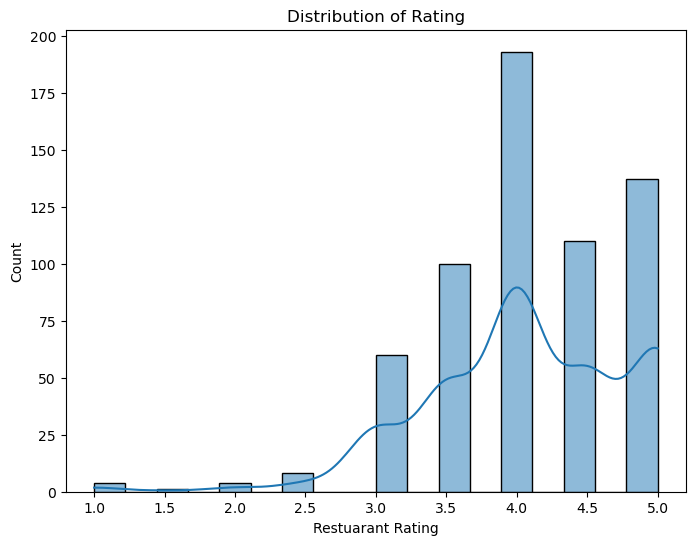

In [392]:
plt.figure(figsize=(8, 6))
sns.histplot(df_filtered['Review Text'], kde=True)
plt.xlabel('Restuarant Rating')
plt.title('Distribution of Rating')
plt.show()


In [393]:
#pairplot doesnt provide meaningful data on binary features

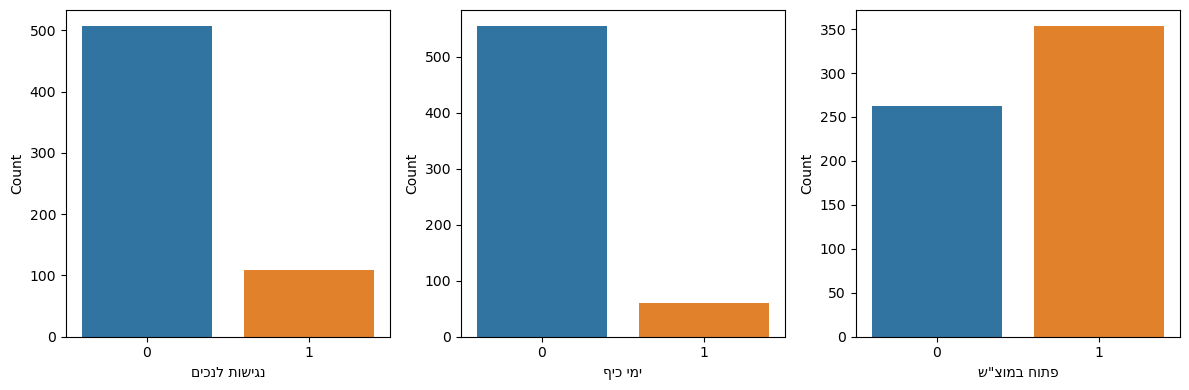

In [394]:
binary_features = ['נגישות לנכים', 'ימי כיף', 'פתוח במוצ"ש']
fig, axes = plt.subplots(nrows=1, ncols=len(binary_features), figsize=(12, 4))

#Iterate over the binary features and create a countplot for each one
for i, feature in enumerate(binary_features):
    sns.countplot(x=feature, data=df_filtered, ax=axes[i])
    # Reverse the value of the label
    axes[i].set_xlabel(feature[::-1])
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


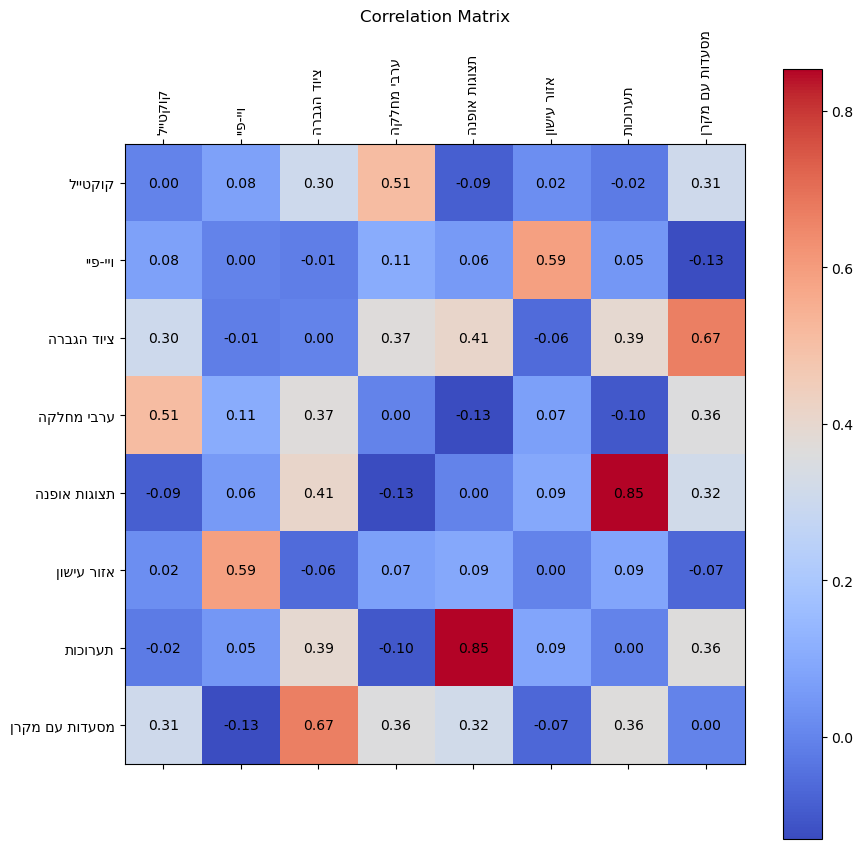

In [395]:
df_selected = df.loc[:, selected_features]
correlation_matrix = df_selected.corr()

# Set the diagonal values to 0.0
np.fill_diagonal(correlation_matrix.values, 0.0)

fig, ax = plt.subplots(figsize=(10, 10))

reversed_labels = [label[::-1] for label in correlation_matrix.columns]  # Reverse the labels

cax = ax.matshow(correlation_matrix, cmap='coolwarm')

# Display numerical values in the correlation matrix plot
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(range(len(correlation_matrix.columns)), reversed_labels, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), reversed_labels)
plt.colorbar(cax)
plt.title("Correlation Matrix")
plt.show()


interval columns not set, guessing: ['קוקטייל', 'ויי-פיי', 'ציוד הגברה', 'ערבי מחלקה', 'תצוגות אופנה', 'אזור עישון', 'תערוכות', 'מסעדות עם מקרן']


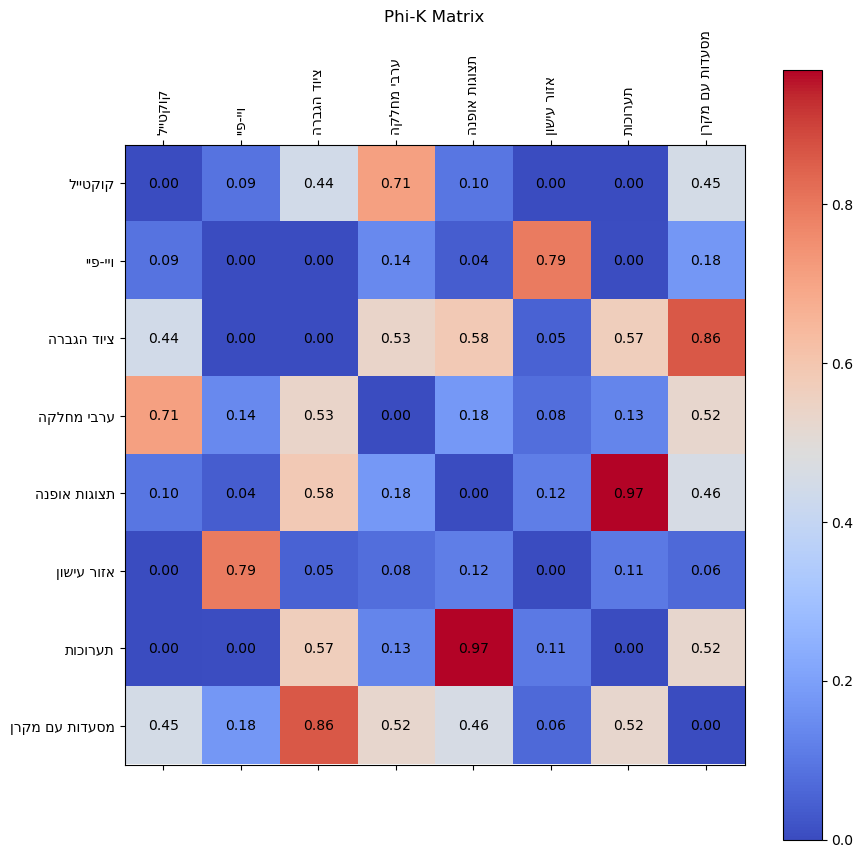

In [396]:
#corr matrix using phik for corr between binary features
df_selected = df.loc[:, selected_features]

# Calculate the Phi-K matrix
correlation_matrix = phik_matrix(df_selected)

# Set the diagonal values to 0.0
correlation_matrix.values[np.diag_indices_from(correlation_matrix)] = 0.0

fig, ax = plt.subplots(figsize=(10, 10))

reversed_labels = [label[::-1] for label in correlation_matrix.columns]  # Reverse the labels

cax = ax.matshow(correlation_matrix, cmap='coolwarm')

# Display numerical values in the correlation matrix plot
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(range(len(correlation_matrix.columns)), reversed_labels, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), reversed_labels)
plt.colorbar(cax)
plt.title("Phi-K Matrix")
plt.show()


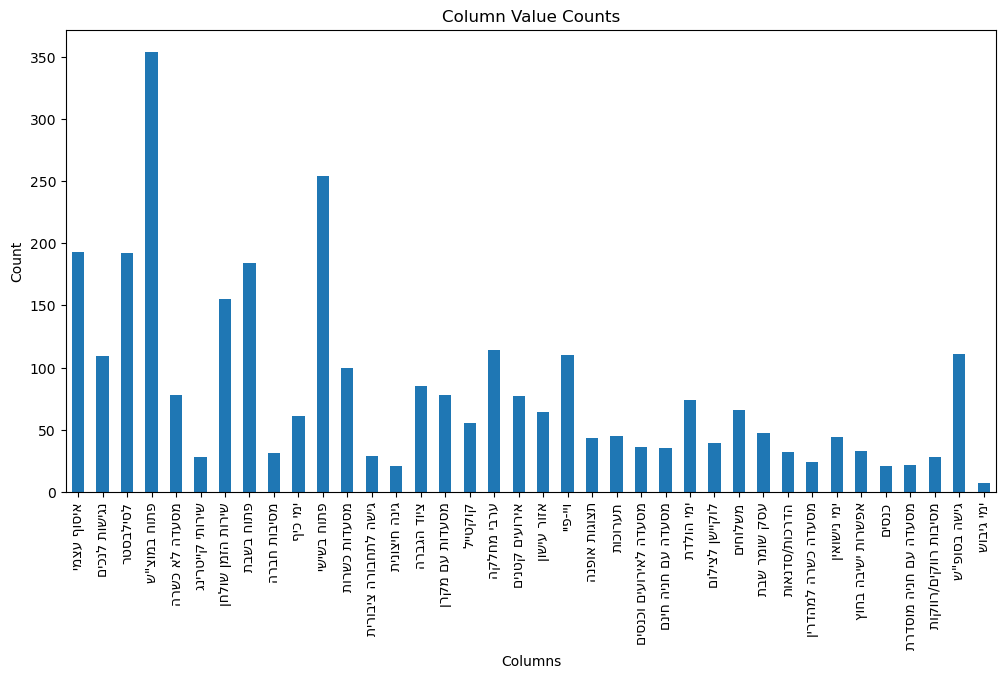

In [416]:
review_text = df_filtered["Review Text"] 
column_counts = df_filtered.drop('Review Text', axis=1).eq(1).sum()
reversed_labels = [label[::-1] for label in column_counts.index]
plt.figure(figsize=(12, 6))
column_counts.index = reversed_labels  # Assign the reversed labels
column_counts.plot(kind='bar')
plt.title('Column Value Counts')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()
df_filtered["Review Text"] = review_text

In [398]:
target_feature = 'Review Text'

# Calculate the correlation between 'Review Text' and all other features
correlations = df.corr()[target_feature].drop(target_feature)

# Find the feature with the highest correlation
max_corr_feature = correlations.idxmax()
max_corr_value = correlations.loc[max_corr_feature]

print(f"The feature with the highest correlation to 'Review Text' is '{max_corr_feature}' with a correlation value of {max_corr_value:f}")


The feature with the highest correlation to 'Review Text' is 'ימי כיף' with a correlation value of 0.160106


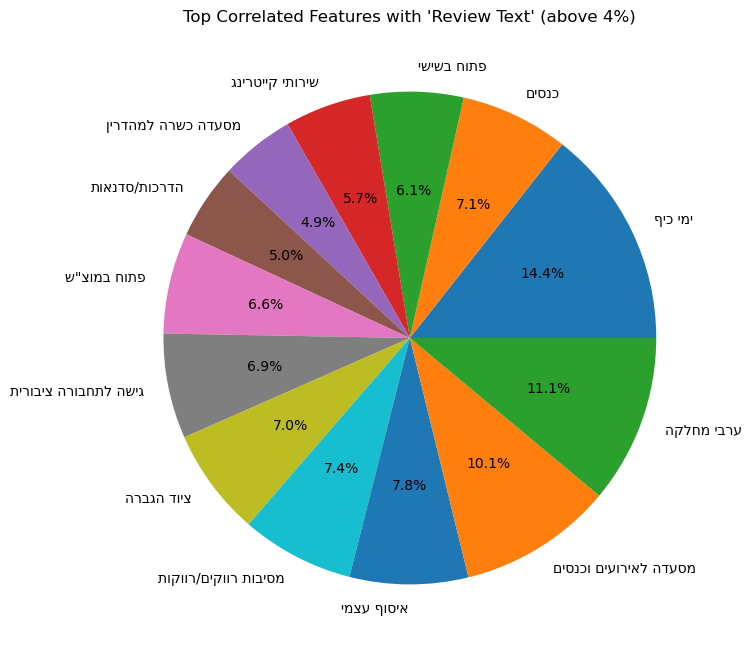

In [399]:
target_feature = 'Review Text'
threshold = 0.05  # Set the correlation threshold here

correlations = df_filtered.corr()[target_feature].drop(target_feature)

# Filter out features with correlation below the threshold
correlations = correlations[correlations.abs() >= threshold]

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Reverse the feature labels
reversed_labels = [label[::-1] for label in sorted_correlations.index]

# Create a pie chart of the top correlated features with reversed labels
correlation_values = sorted_correlations.abs().tolist()  # Take absolute values of the correlations

plt.figure(figsize=(8, 8))
plt.pie(correlation_values, labels=reversed_labels, autopct='%1.1f%%')
plt.title("Top Correlated Features with 'Review Text' (above 4%)")
plt.show()


# Machine Learning

replacement of the rating feature in a binary feature,
sort the rating to '1' is over and equal 4.5 and '0' for under 4.5

In [400]:
df_filtered["rating_clf"] = df_filtered["Review Text"].apply(lambda review_rate: 0 if review_rate < 4.5 else 1)

In [401]:
df_filtered["rating_clf"].value_counts()

0    370
1    247
Name: rating_clf, dtype: int64

In [402]:
review_text = df_filtered["Review Text"] 
df_filtered.drop("Review Text", axis=1, inplace=True)

#(1) Logistic Regrassion Model

In [403]:
logistic_regression_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
#using a punishment penelty on the model 
X = df_filtered.drop("rating_clf", axis=1).values  # Input features
y = df_filtered["rating_clf"].values  # Target label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
#using the logistic regrassion model after the classification we made on the rating feature
logistic_regression_model = logistic_regression_model.fit(X_train,y_train)
lr_classification_report = classification_report(y_test, logistic_regression_model.predict(X_test))
print(lr_classification_report)
mse = mean_squared_error(y_test,  logistic_regression_model.predict(X_test))
print(f"Mean Squared Error: {mse}")

              precision    recall  f1-score   support

           0       0.68      0.77      0.72        77
           1       0.51      0.40      0.45        47

    accuracy                           0.63       124
   macro avg       0.60      0.59      0.59       124
weighted avg       0.62      0.63      0.62       124

Mean Squared Error: 0.3709677419354839


# (2)XGB Model

In [404]:
xgb_mode = xgb.XGBClassifier()
xgb_model = xgb_mode.fit(X_train,y_train)
xgb_classification_report = classification_report(y_test, xgb_model.predict(X_test))
print(xgb_classification_report)
mse = mean_squared_error(y_test,  xgb_model.predict(X_test))
print(f"Mean Squared Error: {mse}")

              precision    recall  f1-score   support

           0       0.69      0.70      0.70        77
           1       0.50      0.49      0.49        47

    accuracy                           0.62       124
   macro avg       0.60      0.60      0.60       124
weighted avg       0.62      0.62      0.62       124

Mean Squared Error: 0.3790322580645161


In [405]:
roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

0.6007184305056645

returning the coulnm after classificate it before

In [407]:
df_filtered["Review Text"] = review_text
df_filtered.drop("rating_clf", axis=1, inplace=True)


# (3)Random Forest Regressor Model

In [408]:
#this is for only the high corr scores from the pie plot
target_feature = 'Review Text'
threshold = 0.05  

correlations = df_filtered.corr()[target_feature].drop(target_feature)

# Filter out features with correlation below the threshold
correlations = correlations[correlations.abs() >= threshold]

# Prepare the data
X = df_filtered[list(correlations.index)].values 
y = df_filtered[target_feature].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

model = RandomForestRegressor()

# Train 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.5073613175006083


# (4)Linear Regression Model

In [409]:
#df_filtered is features more then 20 '1'
X = df_filtered.drop('Review Text', axis=1)
y = df_filtered['Review Text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=150)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)


Mean Squared Error: 0.4362766846252382


This is an implemantation using KFolds

In [410]:
# Define the number of folds for cross-validation
k = 5
X = df_filtered.drop('Review Text', axis=1)
y = df_filtered['Review Text']
# Initialize an empty list to store the MSE scores for each fold
mse_scores = []
f1_list = []

# Initialize the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=100)

# Iterate over the KFold splits
for train_index, test_index in kf.split(X):
    # Split the data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    f1 = r2_score(y_test, y_pred)
    # Calculate the Mean Squared Error (MSE) for this fold
    mse = mean_squared_error(y_test, y_pred)

    # Append the MSE score to the list
    mse_scores.append(mse)
    f1_list.append(f1)
# Calculate the average MSE score across all folds
average_mse = np.mean(mse_scores)
f1_avg = np.mean(f1_list)
print("F1 score:", f1_avg)
print("Average MSE:", average_mse)


F1 score: 0.011830215745532224
Average MSE: 0.515231960110631


In [411]:
df_filtered['גישה בסופ"ש'] = 0
df_filtered.loc[(df_filtered['פתוח במוצ"ש'] == 1) & (df_filtered['פתוח בשישי'] == 1), 'גישה בסופ"ש'] = 1

In [412]:
df_filtered['ימי גיבוש'] =0
df_filtered.loc[(df_filtered['ערבי מחלקה'] == 1) & (df_filtered['ימי כיף'] == 1), 'ימי גיבוש'] = 1
df_filtered.head()

,איסוף עצמי,נגישות לנכים,לסילבסטר,"פתוח במוצ""ש",מסעדה לא כשרה,שירותי קייטרינג,שירות הזמן שולחן,פתוח בשבת,מסיבות חברה,ימי כיף,...,הדרכות/סדנאות,מסעדה כשרה למהדרין,ימי נישואין,אפשרות ישיבה בחוץ,כנסים,מסעדה עם חניה מוסדרת,מסיבות רווקים/רווקות,Review Text,"גישה בסופ""ש",ימי גיבוש
1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4.0,0,0
2,0,0,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,4.5,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5.0,0,0
5,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,4.5,0,0


This is an implemantation after feature manipulation

In [413]:
X = df_filtered.drop('Review Text', axis=1)
y = df_filtered['Review Text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=150)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)


Mean Squared Error: 0.4371905661467396


In [414]:
corr,_ = pointbiserialr(df['מסעדות כשרות'], df['מסעדה לא כשרה'])
print("Correlation between the two contrary features:", corr)


Correlation between the two contrary features: -0.1673045095686168


we can see the weak correlation between the two contrary features

# in conclusion we activated 6 different attempts on the models 
we found the best one is the Logistic Regrassion with a punishment penelty giving us an MSE result of : 0.370 